# Construct design matricies for 7T

## Description
Task onsets are 320 and 960 seconds, each with duration of 320 seconds.


In [1]:
from fsl_mrs.utils import mrs_io
import numpy as np

example_data = mrs_io.read_FID('../simulated_data/fmrs_bold_7T/sub-001/mrs/sub-001_svs.nii.gz')
print(example_data)
print(example_data.hdr_ext['RepetitionTime'])
print(example_data.hdr_ext['RepetitionTime'] * example_data.shape[example_data.dim_position('DIM_DYN')])


task_onsets = np.array([320, 960]) 
task_durations = np.array([320, 320]) 
print(task_onsets / example_data.hdr_ext['RepetitionTime'])
print(task_durations / example_data.hdr_ext['RepetitionTime'])

This file's header extension is currently invalid. Reason: User-defined key ChemicalShiftOffset does not contain a 'Description' field. Setting empty 'Description'.
File sub-001_svs.nii.gz (/Users/wclarke/Library/CloudStorage/OneDrive-Nexus365/projects/special_issue_fmrs/simulated_data/fmrs_bold_7T/sub-001/mrs)
NIfTI-MRS version 0.2
Data shape (1, 1, 1, 2048, 1, 320)
Dimension tags: ['DIM_COIL', 'DIM_DYN', None]
Spectrometer Frequency: 297.0 MHz
Dwelltime (Spectral bandwidth): 1.667E-04 s (6000 Hz)
Nucleus: 1H
Field Strength: 6.98 T

5
1600
[ 64. 192.]
[64. 64.]


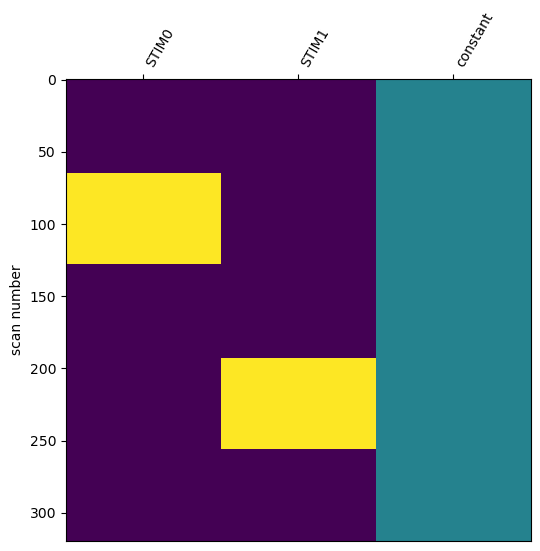

In [2]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Calculations to create the design matrix
tr          = example_data.hdr_ext['RepetitionTime']  # repetition time * number of transients averaged for this demo
n_blocks    = 2  # Number of stimulation blocks
n_scans     = example_data.shape[example_data.dim_position('DIM_DYN')] # Total number of scan points (16)
frame_times = np.arange(n_scans) * tr  # Time point of each data point
conditions  = [f'STIM{i}' for i in range(n_blocks)] # each trial gets its own regressor
duration    = task_durations # Duration of each stimulation block
onsets = task_onsets # Start time of each stimulation block.
events = pd.DataFrame({'trial_type': conditions, 
                       'onset'     : onsets,
                       'duration'  : duration})

# Pass to nilearn function to create design matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model='polynomial',
    drift_order=0, 
    hrf_model=None) 

# Plot the designmatrix for inspection
fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix, axes=fig.gca())

In [3]:
lb_df = pd.read_csv('../regressors/lorentz_lb_297_mhz.csv', index_col=0, names=['Lorentz_lb',])
lb_df.index = design_matrix.index
lb_df

,Lorentz_lb
0,0.511165
5,0.511165
10,0.511165
15,0.511165
20,0.511165
...,...
1575,0.511165
1580,0.511165
1585,0.511165
1590,0.511165


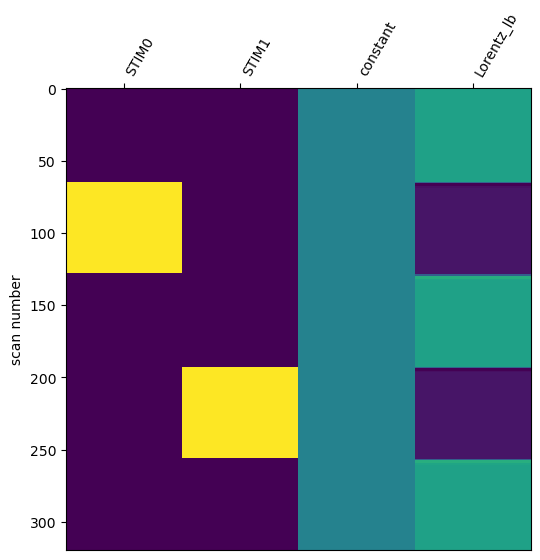

In [4]:
design_matrix_with_lb = pd.concat((design_matrix, lb_df),axis=1)

fig = plt.figure(figsize=(6,6))
_ = plot_design_matrix(design_matrix_with_lb, axes=fig.gca())

In [5]:
design_matrix.to_csv('des_mat_7T_fixed_lb.csv', index=False, header=False)
design_matrix_with_lb.to_csv('des_mat_7T_exact_lb.csv', index=False, header=False)